In [65]:

# designing and implementing CNN in PyTorch to classify fashionMNIST

# accuracy = 9% # Worse than guessing! (And worse than the 35% from feed forward NN) 
# perhaps the already-low resolution of fashionMNIST doesnt benefit from CNN

# datasets available via tensorflow ('beans' looks fun for determining crop health)
# https://www.tensorflow.org/datasets/catalog/overview


## not used here. Ray tune seems a great way to tune hyperparameters
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler



# to find cutting edge algos to draw inspiration from, see this list:
# https://paperswithcode.com/sota/image-classification-on-fashion-mnist


# Hadamard product = element wise multiplication



import numpy as np
from torch import nn, rand, sum
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor    # ToTensor converts PIL image or nparray to FloatTensor


In [15]:
X = rand(1, 10)
print(X)                      # random vector of 10 values, which could be NN outputs for 10-class classifier
print(nn.Softmax(dim=1)(X))   # may wish to put outputs of NN through softmax
print(sum(nn.Softmax(dim=1)(X)))   # showing softmax outputs sum to 1

tensor([[0.1896, 0.2594, 0.7023, 0.0846, 0.5693, 0.1691, 0.3450, 0.9565, 0.2998,
         0.7538]])
tensor([[0.0753, 0.0807, 0.1257, 0.0678, 0.1101, 0.0738, 0.0880, 0.1621, 0.0841,
         0.1324]])
tensor(1.)


In [17]:
# get data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


In [18]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

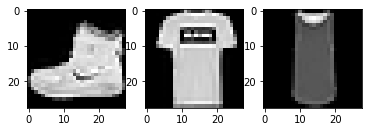

In [19]:
# see first 3 images in training data set
plt.subplot(1,3,1)    
plt.imshow(training_data[0][0][0, :, :], cmap="gray")
plt.subplot(1,3,2)    
plt.imshow(training_data[1][0][0, :, :], cmap="gray")
plt.subplot(1,3,3)    
plt.imshow(training_data[2][0][0, :, :], cmap="gray")
plt.show()

In [20]:
batch_size = 64 # minibatch size

train_dataloader = DataLoader(training_data, batch_size=batch_size) # creates python iterable over dataset
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [50]:
def get_height_or_width_output(n_previous_layer, padding, filter_size, stride):
    """This func can apply to both width or height of matrix
    Returns dimensions of output layer from input layer
    """
    return ( (n_previous_layer + 2*padding - filter_size)/ stride) + 1


#### Using this formula to work out what dimensions I should set the layers to when defining the model
# nn.Conv2d defaults: stride=1, padding=0; 
# filter_size aka kernel_size (width of convolution matrix)
print(get_height_or_width_output(28, 0, 3, 1) )
print(get_height_or_width_output(26, 0, 3, 1) / 2) 

26.0
12.0


In [51]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))




# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)  # outputs 24*24*5 square (12*12 after pooling)
        self.conv2 = nn.Conv2d(6, 16, 3) # outputs 8*8*16 square (4*4 after pooling)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)  #4*4*16=256=total flattened features from previous Conv matrix
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        # outputs 10 values


    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 1)  # max pool essentially doing nothing when set to 1
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # max pool reduces both dimensions of square in half 
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        x = nn.Softmax(dim=1)(x)  # scales outputs vector to sum to 1
        return x

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [52]:
loss_fn = nn.CrossEntropyLoss()     # chosing loss function 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # set optimiser with learning rate

In [53]:
def train(dataloader, model, loss_fn, optimizer):
    """Single training epoch, looping through mini-batches as set in dataloader obj"""
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()  # setting weights to zero - not sure if doing this on every epoch or not
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:     # printing diagnostics on every 100th batch
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [54]:
def test(dataloader, model, loss_fn):
    """test performance of model on test dataset"""
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()    # puts the model into eval model (instead of train); a form of switch
    test_loss, correct = 0, 0
    with torch.no_grad():    # no_grad disables gradient calculation
                               # anytime we're applying the model, put it within no_grad so no updates made
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)         
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches   # shorthand for: test_loss = test_loss / num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [55]:
### training process
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)   
    test(test_dataloader, model, loss_fn)   # tells you how it's doing
print("Done!")

Epoch 1
-------------------------------
loss: 2.302513  [    0/60000]
loss: 2.302863  [ 6400/60000]
loss: 2.302308  [12800/60000]
loss: 2.302303  [19200/60000]
loss: 2.303178  [25600/60000]
loss: 2.303082  [32000/60000]
loss: 2.303248  [38400/60000]
loss: 2.302658  [44800/60000]
loss: 2.302197  [51200/60000]
loss: 2.304625  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302734 

Epoch 2
-------------------------------
loss: 2.302351  [    0/60000]
loss: 2.302719  [ 6400/60000]
loss: 2.302102  [12800/60000]
loss: 2.302131  [19200/60000]
loss: 2.303038  [25600/60000]
loss: 2.302890  [32000/60000]
loss: 2.303108  [38400/60000]
loss: 2.302491  [44800/60000]
loss: 2.302042  [51200/60000]
loss: 2.304449  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302559 

Epoch 3
-------------------------------
loss: 2.302193  [    0/60000]
loss: 2.302575  [ 6400/60000]
loss: 2.301896  [12800/60000]
loss: 2.301966  [19200/60000]
loss: 2.302899  [25600/60000]
loss: 2.302711  [32000/600

<All keys matched successfully>

In [61]:
# making a prediction for a single data point
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()    # eval mode is also prediction mode
x, y = test_data[1][0], test_data[0][1]
print(x.shape)
print(y)
softmax = nn.Softmax(dim=1)  # defining softmax for our uses
with torch.no_grad():    # anytime we're applying the model, put it within no_grad so no updates made
    pred = model(x[None, ...])   # model(x) doesn't work, need [None,...] too 
                                # because pytorch expects a batch, not a single value
                                # https://stackoverflow.com/questions/57237381/runtimeerror-expected-4-dimensional-input-for-4-dimensional-weight-32-3-3-but
    print(pred)
    print('class with highest prediction: ' + str(classes[pred[0].argmax(0)]))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

torch.Size([1, 28, 28])
9
tensor([[0.0950, 0.1118, 0.1027, 0.1081, 0.0982, 0.1043, 0.0951, 0.0900, 0.1005,
         0.0943]])
class with highest prediction: Trouser
Predicted: "Trouser", Actual: "Ankle boot"


In [62]:
# view weights for each layer
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: conv1.weight | Size: torch.Size([6, 1, 3, 3]) | Values : tensor([[[[-0.1057,  0.0530, -0.1202],
          [ 0.2602,  0.0943, -0.1224],
          [ 0.0051,  0.1386, -0.1116]]],


        [[[ 0.1582,  0.1826, -0.0364],
          [ 0.0590,  0.2801,  0.0622],
          [-0.0244,  0.2316, -0.1661]]]], grad_fn=<SliceBackward>) 

Layer: conv1.bias | Size: torch.Size([6]) | Values : tensor([-0.3077, -0.1342], grad_fn=<SliceBackward>) 

Layer: conv2.weight | Size: torch.Size([16, 6, 3, 3]) | Values : tensor([[[[-0.1352, -0.1257, -0.0583],
          [-0.0585,  0.1126, -0.1161],
          [-0.0823, -0.1116,  0.1002]],

         [[ 0.0469, -0.0897, -0.0770],
          [ 0.0393, -0.1159,  0.1216],
          [ 0.0918, -0.0914, -0.1337]],

         [[ 0.1260, -0.0190, -0.0460],
          [-0.0173,  0.0201, -0.0485],
          [-0.0578,  0.1249, -0.0157]],

         [[-0.0161,  0.0242,  0.1189],
          [-0.0871,  0.1346,  0.1307],
          [-0.1270,  0.0803, -0.1210]],

         [[-0.0997, 